In [41]:
# Importation des bibliothèques nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, count, median, year, lit, datediff, to_date, current_date, when, count
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder, PCA
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql.functions import



In [42]:
# Initialisation Spark
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# Chargement des données

In [43]:
data_path = "données_brute.csv"  # Remplacez par le chemin réel de votre fichier
data = spark.read.csv(data_path, header=True, inferSchema=True)

## Exploration des données

In [44]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedC

In [45]:
data.show(5)

+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+----------

In [46]:
data.describe().show()

+-------+------------------+------------------+---------+--------------+------------------+-------------------+------------------+-----------+-----------------+------------------+------------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+-------------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------+---------+-------------------+
|summary|                ID|        Year_Birth|Education|Marital_Status|            Income|            Kidhome|          Teenhome|Dt_Customer|          Recency|          MntWines|         MntFruits|  MntMeatProducts|   MntFishProducts| MntSweetProducts|    MntGoldProds|NumDealsPurchases|   NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|       AcceptedCmp3|       AcceptedCmp4|       AcceptedCmp5|       AcceptedCmp1|        AcceptedCmp2|       

In [47]:
print(f"Nombre de lignes : {data.count()}")
print(f"Nombre de colonnes : {len(data.columns)}")

Nombre de lignes : 2240
Nombre de colonnes : 29


In [49]:
# Vérification des valeurs manquantes
missing_values = data.select([count(when(isnull(c), c)).alias(c) for c in data.columns])
missing_values.show()

+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
| ID|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+---

In [ ]:
# Vérification des types de données
print(data.dtypes)

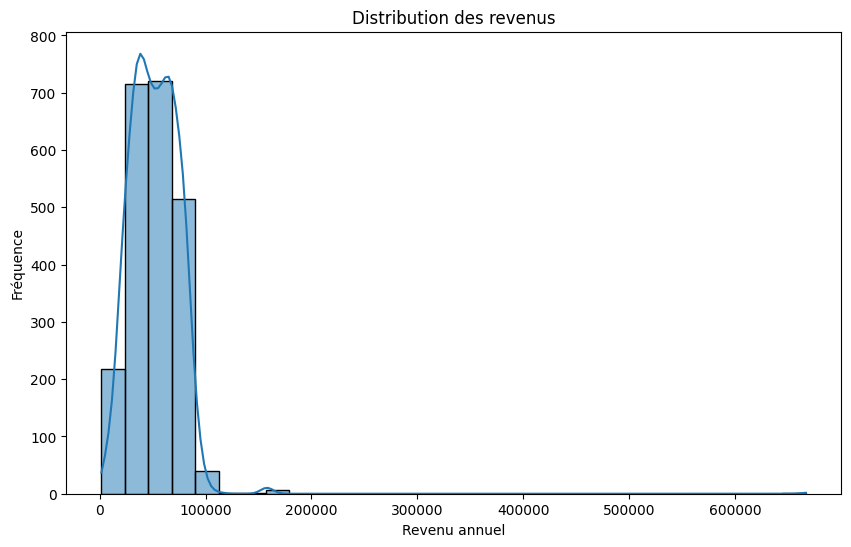

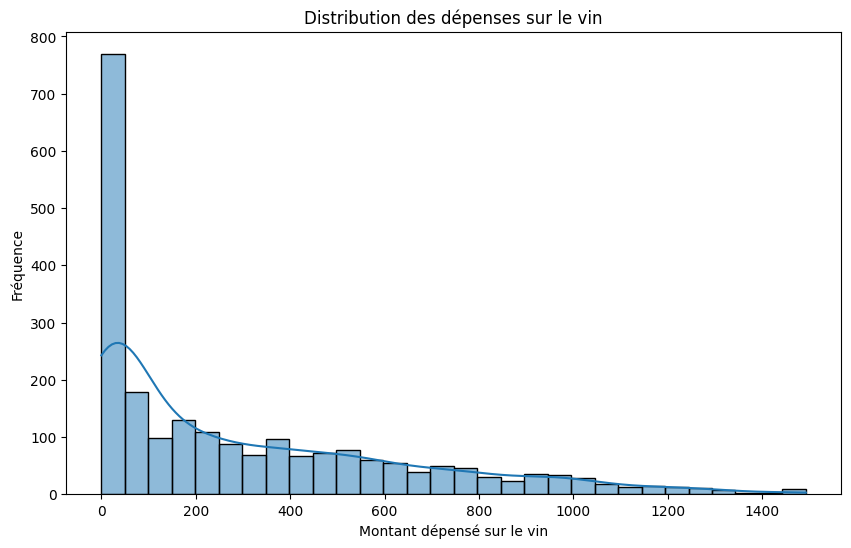

In [53]:
# Convert the 'Income' column to a Pandas Series
income_data = data.select('Income').toPandas()['Income']

# Now use income_data with sns.histplot
plt.figure(figsize=(10, 6))
sns.histplot(income_data, kde=True, bins=30)
plt.title("Distribution des revenus")
plt.xlabel("Revenu annuel")
plt.ylabel("Fréquence")
plt.show()

# Do the same for 'MntWines'
wines_data = data.select('MntWines').toPandas()['MntWines']

plt.figure(figsize=(10, 6))
sns.histplot(wines_data, kde=True, bins=30)
plt.title("Distribution des dépenses sur le vin")
plt.xlabel("Montant dépensé sur le vin")
plt.ylabel("Fréquence")
plt.show()

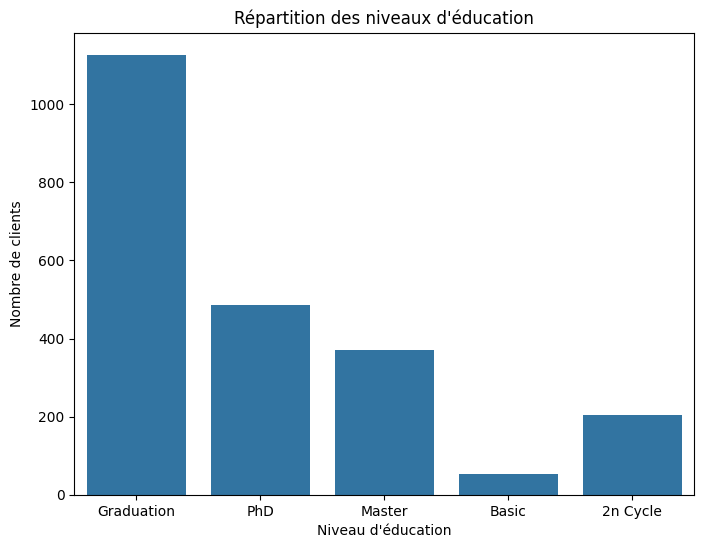

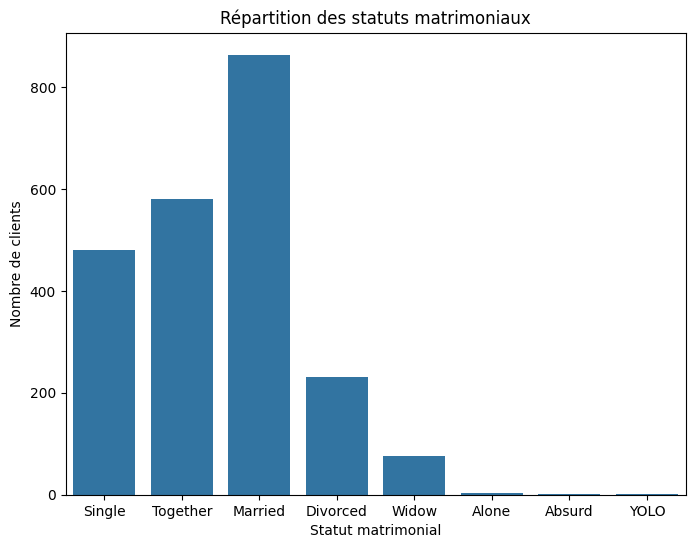

In [55]:
# Répartition des niveaux d'éducation
plt.figure(figsize=(8, 6))
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_data = data.toPandas()
sns.countplot(x='Education', data=pandas_data) # Use the Pandas DataFrame here
plt.title("Répartition des niveaux d'éducation")
plt.xlabel("Niveau d'éducation")
plt.ylabel("Nombre de clients")
plt.show()

# Répartition des statuts matrimoniaux
plt.figure(figsize=(8, 6))
sns.countplot(x='Marital_Status', data=pandas_data) # Use the Pandas DataFrame here
plt.title("Répartition des statuts matrimoniaux")
plt.xlabel("Statut matrimonial")
plt.ylabel("Nombre de clients")
plt.show()

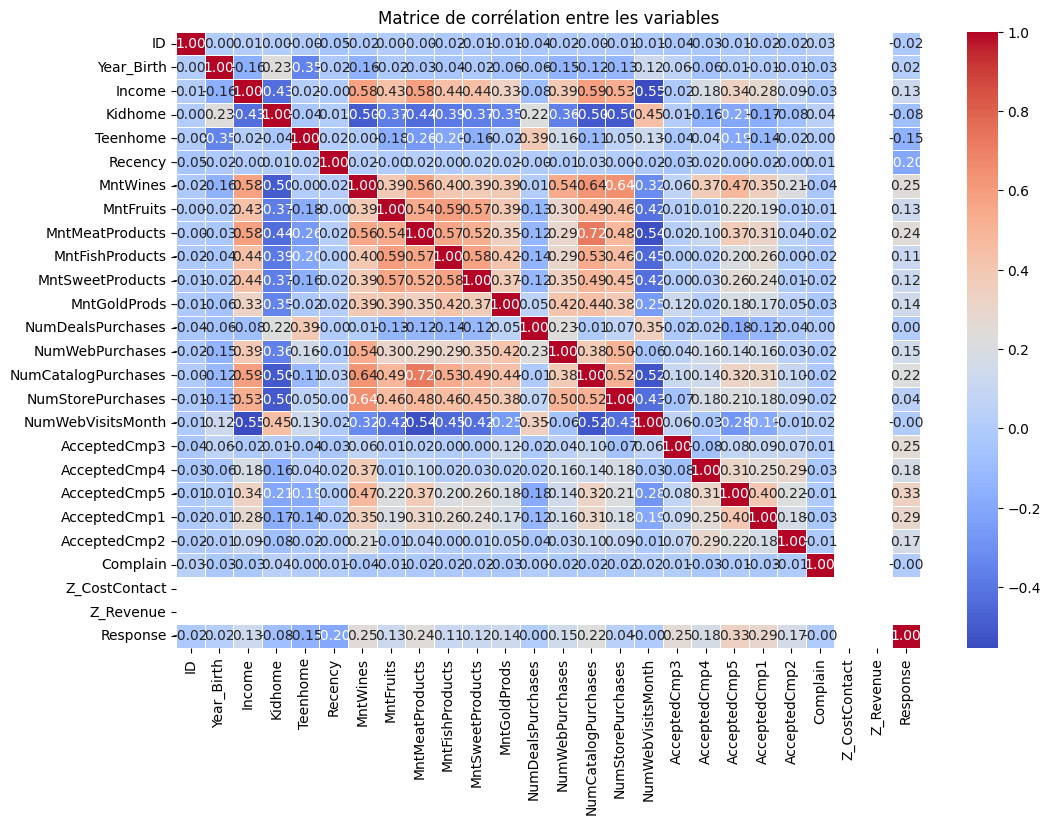

In [58]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_data = data.toPandas()

# Select only numerical columns for correlation calculation
numerical_data = pandas_data.select_dtypes(include=['number'])

# Calculate the correlation matrix using pandas.DataFrame.corr()
corr = numerical_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation entre les variables")
plt.show()

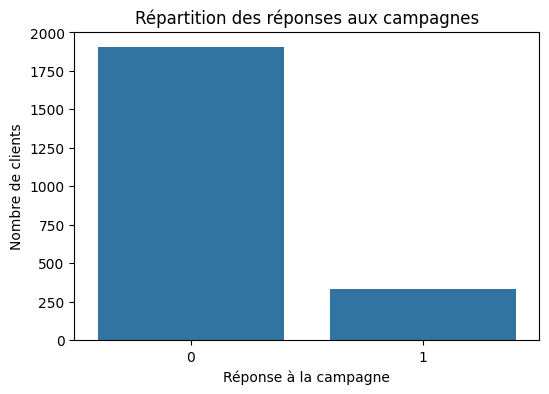

In [60]:
# Répartition de la réponse à la campagne
plt.figure(figsize=(6, 4))

# Convert the PySpark DataFrame 'data' to a Pandas DataFrame
pandas_data = data.toPandas()

# Use the Pandas DataFrame 'pandas_data' with sns.countplot
sns.countplot(x='Response', data=pandas_data)

plt.title("Répartition des réponses aux campagnes")
plt.xlabel("Réponse à la campagne")
plt.ylabel("Nombre de clients")
plt.show()

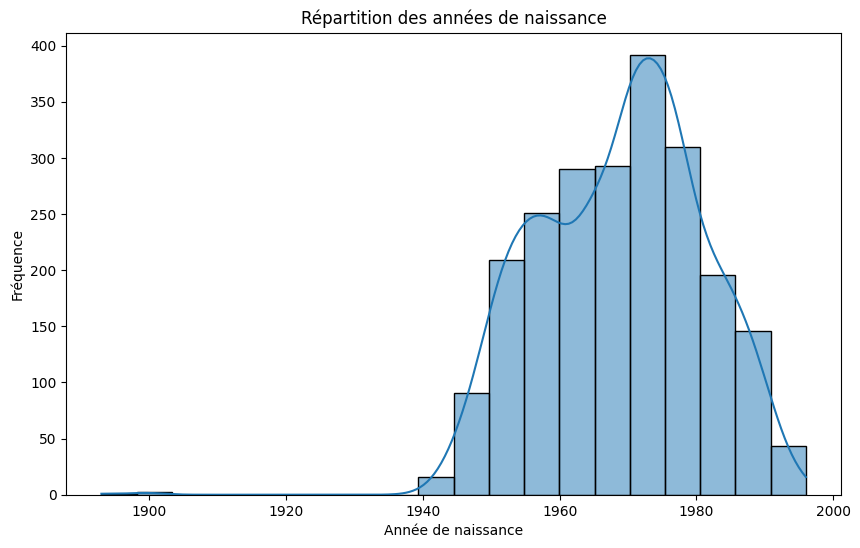

In [62]:
# Extraction de l'année de naissance et analyse de la distribution
data = data.withColumn('Year_Birth', year(to_date(col('Year_Birth'), 'yyyy')))
# Use PySpark's to_date and year functions

plt.figure(figsize=(10, 6))
sns.histplot(data.select('Year_Birth').toPandas()['Year_Birth'], bins=20, kde=True)
# Convert to pandas DataFrame for plotting
plt.title("Répartition des années de naissance")
plt.xlabel("Année de naissance")
plt.ylabel("Fréquence")
plt.show()

# Prétraitement des données

## Gestion des Valeurs Manquantes


In [ ]:
for col_name in data.columns:
    missing_count = data.filter(isnull(col(col_name))).count()
    print(f"La colonne '{col_name}' contient {missing_count} valeurs manquantes.")

La colonne 'ID' contient 0 valeurs manquantes.
La colonne 'Year_Birth' contient 0 valeurs manquantes.
La colonne 'Education' contient 0 valeurs manquantes.
La colonne 'Marital_Status' contient 0 valeurs manquantes.
La colonne 'Income' contient 24 valeurs manquantes.
La colonne 'Kidhome' contient 0 valeurs manquantes.
La colonne 'Teenhome' contient 0 valeurs manquantes.
La colonne 'Dt_Customer' contient 0 valeurs manquantes.
La colonne 'Recency' contient 0 valeurs manquantes.
La colonne 'MntWines' contient 0 valeurs manquantes.
La colonne 'MntFruits' contient 0 valeurs manquantes.
La colonne 'MntMeatProducts' contient 0 valeurs manquantes.
La colonne 'MntFishProducts' contient 0 valeurs manquantes.
La colonne 'MntSweetProducts' contient 0 valeurs manquantes.
La colonne 'MntGoldProds' contient 0 valeurs manquantes.
La colonne 'NumDealsPurchases' contient 0 valeurs manquantes.
La colonne 'NumWebPurchases' contient 0 valeurs manquantes.
La colonne 'NumCatalogPurchases' contient 0 valeurs m

In [ ]:
print(data.select("Income").show())

+------+
|Income|
+------+
| 58138|
| 46344|
| 71613|
| 26646|
| 58293|
| 62513|
| 55635|
| 33454|
| 30351|
|  5648|
|  NULL|
|  7500|
| 63033|
| 59354|
| 17323|
| 82800|
| 41850|
| 37760|
| 76995|
| 33812|
+------+
only showing top 20 rows

None


In [ ]:
# Calcul de la médiane de la colonne "Income"
median_income = data.select(median(col("Income"))).collect()[0][0]

# Imputation des valeurs manquantes par la médiane
data = data.fillna(median_income, subset=["Income"])

# Affichage eds résultats
data.show()

+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+----------

## Ingénierie des Caractéristiques

In [ ]:
# Calcul de l'âge :
annee_actuelle = lit(2024)
data = data.withColumn("Age", annee_actuelle - col("Year_Birth"))

# Calcul du montant total dépensé:
data = data.withColumn("DépenseTotale",col("MntWines") + col("MntFruits") + col("MntMeatProducts") + col("MntFishProducts") + col("MntSweetProducts") + col("MntGoldProds"))

# Calcul de l'ancienneté:
data = data.withColumn("Dt_Customer", to_date(col("Dt_Customer"), "yyyy-MM-dd"))
data = data.withColumn("Anciennete", datediff(current_date(), col("Dt_Customer")))

# Calcul du nombre total d'enfant:
data = data.withColumn("TotalChildren", col("Kidhome") + col("Teenhome"))

## Mise à l'échelle des Caractéristiques

In [ ]:
# Vérification des valeurs nulles
data = data.fillna(0, subset=["Age", "Recency", "DépenseTotale", "Anciennete", "TotalChildren"])

In [ ]:
# Sélection des caractéristiques à mettre à l'échelle:
caracteristiques_a_echelle = ["Age", "Recency", "DépenseTotale", "Anciennete","TotalChildren"]
assembler = VectorAssembler(inputCols=caracteristiques_a_echelle, outputCol="features")
data = assembler.transform(data)

In [ ]:
data.select("features").show(truncate=False)

+--------------------------+
|features                  |
+--------------------------+
|[67.0,58.0,1617.0,0.0,0.0]|
|[70.0,38.0,27.0,0.0,2.0]  |
|[59.0,26.0,776.0,0.0,0.0] |
|[40.0,26.0,53.0,0.0,1.0]  |
|[43.0,94.0,422.0,0.0,1.0] |
|[57.0,16.0,716.0,0.0,1.0] |
|[53.0,34.0,590.0,0.0,1.0] |
|[39.0,32.0,169.0,0.0,1.0] |
|[50.0,19.0,46.0,0.0,1.0]  |
|[74.0,68.0,49.0,0.0,2.0]  |
|[41.0,11.0,19.0,0.0,1.0]  |
|[48.0,59.0,61.0,0.0,0.0]  |
|[65.0,82.0,1102.0,0.0,0.0]|
|[72.0,53.0,310.0,0.0,2.0] |
|[37.0,38.0,46.0,0.0,0.0]  |
|[78.0,23.0,1315.0,0.0,0.0]|
|[44.0,51.0,96.0,0.0,2.0]  |
|[78.0,20.0,317.0,0.0,0.0] |
|[75.0,91.0,1782.0,0.0,1.0]|
|[39.0,86.0,133.0,0.0,1.0] |
+--------------------------+
only showing top 20 rows



In [ ]:
# Standardisation des données
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

## Encodage des Caractéristiques Catégorielles

In [ ]:
# Indexation des chaînes:
colonnes_categorieles = ["Education", "Marital_Status"]
indexer = StringIndexer(inputCols=colonnes_categorieles, outputCols=[col + "_index" for col in colonnes_categorieles])
data_indexee = indexer.fit(data).transform(data)


In [ ]:
# Encodage one-hot:
encoder = OneHotEncoder(inputCols=[col + "_index" for col in colonnes_categorieles],
                          outputCols=[col + "_encoded" for col in colonnes_categorieles])
data_encodée = encoder.fit(data_indexee).transform(data_indexee)

## Données Finales Prétraitées

In [ ]:
# Final VectorAssembler avec "scaledFeatures"
final_assembler = VectorAssembler(inputCols=["scaledFeatures","Education_encoded", "Marital_Status_encoded"], outputCol="features_")
data_finale = final_assembler.transform(data_encodée)

# Analyse en Composantes Principales

In [ ]:
# Application de PCA pour réduire la dimensionnalité à 2 dimensions
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pca_features")
pca_model = pca.fit(data_finale)
data_pca = pca_model.transform(data_finale)

# Affichage des premières lignes du résultat du PCA
data_pca.select("ID", "pca_features").show(5)


+----+--------------------+
|  ID|        pca_features|
+----+--------------------+
|5524|[-2.1138930687646...|
|2174|[1.62754695414056...|
|4141|[-1.0960940433890...|
|6182|[0.74174572901749...|
|5324|[0.28744019764313...|
+----+--------------------+
only showing top 5 rows



# Développement des méthodes d’apprentissage

## Modèle K-means

**Trouver le meilleur nombre de clusters k**

In [ ]:
for k in range(2, 11):
    kmeans = KMeans(featuresCol="pca_features", k=k, seed=42)
    model = kmeans.fit(data_pca)
    predictions = model.transform(data_pca)
    evaluator = ClusteringEvaluator(featuresCol="pca_features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette = evaluator.evaluate(predictions)
    print(f"Pour k = {k}, Silhouette Score = {silhouette}")


Pour k = 2, Silhouette Score = 0.5632952501029738
Pour k = 3, Silhouette Score = 0.5347301392786029
Pour k = 4, Silhouette Score = 0.5456489869006222
Pour k = 5, Silhouette Score = 0.5708954149193984
Pour k = 6, Silhouette Score = 0.5326051808810424
Pour k = 7, Silhouette Score = 0.5152008206355212
Pour k = 8, Silhouette Score = 0.518165377291698
Pour k = 9, Silhouette Score = 0.5313165651023535
Pour k = 10, Silhouette Score = 0.5378164977234189


**Implémentation du meilleur modèle**

In [ ]:
# Initialiser le modèle K-Means avec un nombre de clusters k
kmeans = KMeans(featuresCol="pca_features", k=5, seed=42)

# Entraîner le modèle K-Means
kmeans_model = kmeans.fit(data_pca)

# Appliquer le modèle sur les données pour obtenir les prédictions
clusters = kmeans_model.transform(data_pca)

# Afficher les clusters obtenus
clusters.select("ID","pca_features","prediction").show()

+----+--------------------+----------+
|  ID|        pca_features|prediction|
+----+--------------------+----------+
|5524|[-2.1138930687646...|         4|
|2174|[1.62754695414056...|         2|
|4141|[-1.0960940433890...|         3|
|6182|[0.74174572901749...|         0|
|5324|[0.28744019764313...|         0|
|7446|[-0.0827150054868...|         0|
| 965|[0.07327852236561...|         0|
|6177|[0.60660130327533...|         0|
|4855|[0.72498794866028...|         0|
|5899|[1.58609428705428...|         2|
|1994|[0.78173123523821...|         0|
| 387|[-0.2299068001127...|         0|
|2125|[-1.5055452912953...|         4|
|8180|[1.28615434522532...|         2|
|2569|[-0.1798884610142...|         0|
|2114|[-1.7807824217540...|         4|
|9736|[1.61210194734521...|         0|
|4939|[-0.6037159549222...|         1|
|6565|[-1.3991842321799...|         4|
|2278|[0.63996724110366...|         0|
+----+--------------------+----------+
only showing top 20 rows



**Résultat:**

In [ ]:
clusters.groupBy("prediction").mean("Age", "Recency", "DépenseTotale", "TotalChildren").show()

+----------+-----------------+------------------+------------------+-------------------+
|prediction|         avg(Age)|      avg(Recency)|avg(DépenseTotale)| avg(TotalChildren)|
+----------+-----------------+------------------+------------------+-------------------+
|         1|62.93214285714286| 59.25714285714286| 586.8303571428571|              0.925|
|         3|45.58688524590164|39.049180327868854|1333.4262295081967|0.13442622950819672|
|         4|66.44642857142857|            60.325|1454.5428571428572|0.14642857142857144|
|         2|60.62326869806094| 55.58725761772853| 172.0831024930748|  2.141274238227147|
|         0|46.32016348773842|38.083106267029976|207.45776566757493| 1.0299727520435968|
+----------+-----------------+------------------+------------------+-------------------+



## Gaussian Mixture Model (GMM)

**Choisir le bon nombre de clusters k**

In [ ]:
# Nombre total de données
N = data_finale.count()

# Calcul des métriques pour chaque k
for k in range(2, 11):
    gmm = GaussianMixture(featuresCol="pca_features", k=k, seed=42)
    model = gmm.fit(data_pca)
    summary = model.summary

    # Dimension des données (taille du vecteur des caractéristiques)
    d = len(data_pca.select("pca_features").first()[0])

    # Nombre de paramètres
    numParameters = k * (d + d * (d + 1) / 2 + 1) - 1

    # Calcul du BIC et AIC
    logLikelihood = summary.logLikelihood
    bic = numParameters * np.log(N) - 2 * logLikelihood
    aic = 2 * numParameters - 2 * logLikelihood

    # Afficher les résultats
    print(f"Pour k = {k}: Log-likelihood = {logLikelihood}, BIC = {bic}, AIC = {aic}")


Pour k = 2: Log-likelihood = -6667.21084168096, BIC = 13419.278225955259, AIC = 13356.42168336192
Pour k = 3: Log-likelihood = -6642.9986749590835, BIC = 13417.1392793806, AIC = 13319.997349918167
Pour k = 4: Log-likelihood = -6592.183202904812, BIC = 13361.793722141152, AIC = 13230.366405809624
Pour k = 5: Log-likelihood = -6174.8028217052815, BIC = 12573.318346611186, AIC = 12407.605643410563
Pour k = 6: Log-likelihood = -5883.702761201731, BIC = 12037.40361247318, AIC = 11837.405522403462
Pour k = 7: Log-likelihood = -5840.302051150117, BIC = 11996.887579239046, AIC = 11762.604102300234
Pour k = 8: Log-likelihood = -5813.205812251768, BIC = 11988.980488311443, AIC = 11720.411624503537
Pour k = 9: Log-likelihood = -5794.945944758015, BIC = 11998.74614019303, AIC = 11695.89188951603
Pour k = 10: Log-likelihood = -5767.310218873036, BIC = 11989.760075292168, AIC = 11652.620437746073


**Implémentation du meilleur modèle**

In [ ]:
# Initialiser le modèle Gaussian Mixture
gmm = GaussianMixture(featuresCol="pca_features", k=6, seed=42)  # k=5 clusters

# Entraîner le modèle sur les données
gmm_model = gmm.fit(data_pca)

# Appliquer le modèle pour obtenir les clusters et probabilités
gmm_clusters = gmm_model.transform(data_pca)

# Afficher les résultats
gmm_clusters.select("ID", "prediction", "probability").show(truncate=False)

+----+----------+----------------------------------------------------------------------------------------------------------------------------------+
|ID  |prediction|probability                                                                                                                       |
+----+----------+----------------------------------------------------------------------------------------------------------------------------------+
|5524|0         |[0.7633400262107171,0.043751407232637755,8.792284290196422E-15,0.18896096283771235,0.003947603718915184,8.792284290196422E-15]    |
|2174|5         |[0.04852655811441119,0.005174730872919844,5.551554166797947E-16,3.8135430826976755E-5,7.33381581716737E-4,0.9455271940001246]     |
|4141|3         |[0.013795634361885772,0.3545691591749944,3.700282188621822E-15,0.629298592270744,0.0023366141923684956,3.700282188621822E-15]     |
|6182|2         |[1.163581857796764E-7,0.006551488456834552,0.9842542548234104,0.009026333908131493,1.6780

## Bisecting K-Means

**Trouver le meilleur nombre de clusters k**

In [ ]:
for k in range(2, 11):  # Tester entre 2 et 10 clusters
    bkm = BisectingKMeans(featuresCol="pca_features", k=k, seed=42)
    model = bkm.fit(data_pca)
    predictions = model.transform(data_pca)
    evaluator = ClusteringEvaluator(featuresCol="pca_features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette = evaluator.evaluate(predictions)
    print(f"Pour k = {k}, Silhouette Score = {silhouette}")

Pour k = 2, Silhouette Score = 0.5632952501029738
Pour k = 3, Silhouette Score = 0.498872807013193
Pour k = 4, Silhouette Score = 0.5317981543341037
Pour k = 5, Silhouette Score = 0.43419054499172643
Pour k = 6, Silhouette Score = 0.4135853238984609
Pour k = 7, Silhouette Score = 0.4484995543308394
Pour k = 8, Silhouette Score = 0.42811343506191135
Pour k = 9, Silhouette Score = 0.4162509412524957
Pour k = 10, Silhouette Score = 0.44411393805577204


**Implémentation du meilleur modèle**

In [ ]:
# Initialiser le modèle Bisecting K-Means
bkm = BisectingKMeans(featuresCol="pca_features", k=2, seed=42)  # k=5 clusters

# Entraîner le modèle
bkm_model = bkm.fit(data_pca)

# Appliquer le modèle pour obtenir les clusters
bkm_clusters = bkm_model.transform(data_pca)

# Afficher les résultats
bkm_clusters.select("ID", "prediction").show(10, truncate=False)


+----+----------+
|ID  |prediction|
+----+----------+
|5524|0         |
|2174|1         |
|4141|0         |
|6182|1         |
|5324|1         |
|7446|1         |
|965 |1         |
|6177|1         |
|4855|1         |
|5899|1         |
+----+----------+
only showing top 10 rows



In [ ]:
bkm_clusters.groupBy("prediction").mean("Income", "Age", "DépenseTotale").show()

+----------+-----------------+-----------------+------------------+
|prediction|      avg(Income)|         avg(Age)|avg(DépenseTotale)|
+----------+-----------------+-----------------+------------------+
|         1|41883.62011577424|53.28437047756874|235.01447178002894|
|         0| 68915.9557109557|58.27039627039627| 1203.027972027972|
+----------+-----------------+-----------------+------------------+



# Évaluation des performances

## Visualisation des clusters

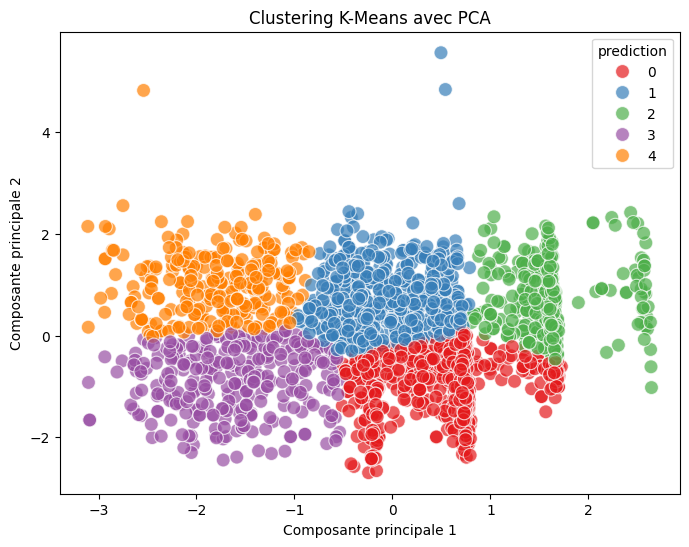

In [ ]:
# Convertir les données PCA et les clusters en un DataFrame pandas pour la visualisation
pandas_df = clusters.select("ID", "pca_features", "prediction").toPandas()
pandas_df[['pca_1', 'pca_2']] = pandas_df['pca_features'].apply(lambda x: pd.Series(x.toArray()))
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pandas_df, x='pca_1', y='pca_2', hue='prediction', palette='Set1', s=100, alpha=0.7)
plt.title('Clustering K-Means avec PCA')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()


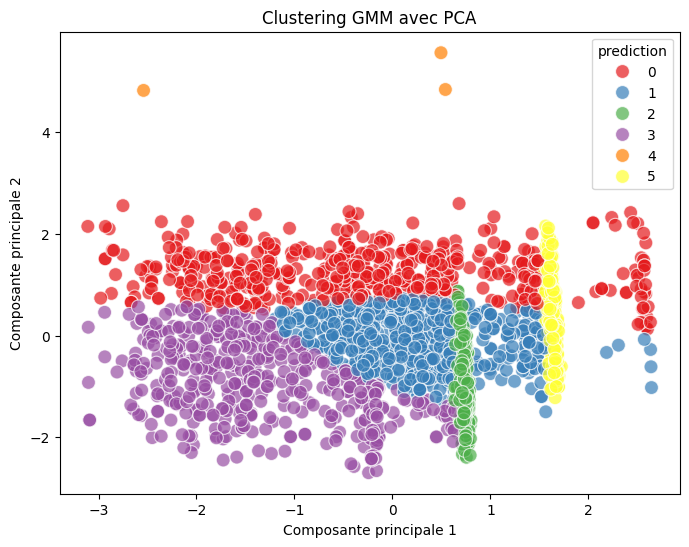

In [ ]:
# GMM
gmm_df = gmm_clusters.select("ID", "pca_features", "prediction").toPandas()
gmm_df[['pca_1', 'pca_2']] = gmm_df['pca_features'].apply(lambda x: pd.Series(x.toArray()))
plt.figure(figsize=(8, 6))
sns.scatterplot(data=gmm_df, x='pca_1', y='pca_2', hue='prediction', palette='Set1', s=100, alpha=0.7)
plt.title('Clustering GMM avec PCA')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

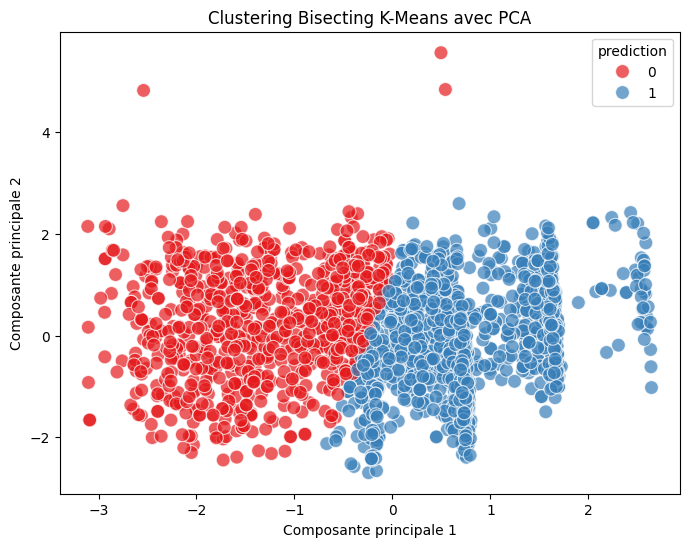

In [ ]:
# Bisecting K-Means
bkm_df = bkm_clusters.select("ID", "pca_features", "prediction").toPandas()
bkm_df[['pca_1', 'pca_2']] = bkm_df['pca_features'].apply(lambda x: pd.Series(x.toArray()))
plt.figure(figsize=(8, 6))
sns.scatterplot(data=bkm_df, x='pca_1', y='pca_2', hue='prediction', palette='Set1', s=100, alpha=0.7)
plt.title('Clustering Bisecting K-Means avec PCA')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()


## Comparaisions de performance  

In [ ]:
# Silhouette Score pour K-Means, GMM et Bisecting K-Means
evaluator = ClusteringEvaluator(featuresCol="pca_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

# Appliquez cette métrique pour K-Means, GMM et Bisecting K-Means
silhouette_kmeans = evaluator.evaluate(clusters)
silhouette_gmm = evaluator.evaluate(gmm_clusters)
silhouette_bkm = evaluator.evaluate(bkm_clusters)

print(f"Silhouette Score pour K-Means : {silhouette_kmeans}")
print(f"Silhouette Score pour GMM : {silhouette_gmm}")
print(f"Silhouette Score pour Bisecting K-Means : {silhouette_bkm}")


Silhouette Score pour K-Means : 0.5708954149193984
Silhouette Score pour GMM : 0.2052461813447454
Silhouette Score pour Bisecting K-Means : 0.5632952501029738


In [ ]:
# Log-likelihood du modèle
log_likelihood = gmm_model.summary.logLikelihood
print(f"Log-likelihood: {log_likelihood}")

# AIC (Akaike Information Criterion)
print(f"AIC: {aic}")

Log-likelihood: -5883.702761201731
AIC: 11652.620437746073


In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame.
data_finale = data_finale.toPandas()

# Save the Pandas DataFrame to a CSV file.
data_finale.to_csv('données_intermédiaires.csv', index=False)

In [37]:
# Convert the PySpark DataFrame to a Pandas DataFrame.
data_pca = data_pca.toPandas()

# Save the Pandas DataFrame to a CSV file.
data_pca.to_csv('données_finales.csv', index=False)